### Installing required packages

In [1]:
! pip install numpy
! pip install pandas

You should consider upgrading via the '/Users/sohomdash/.pyenv/versions/3.10.0/bin/python3.10 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/sohomdash/.pyenv/versions/3.10.0/bin/python3.10 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import json
from os import path
from pprint import pprint

### Data extraction

In [3]:
def prepare_data(data, variant):
  file = open(f"./data/{variant}.txt")

  while True:
    content=file.readline()
    if not content:
      break
    
    if content[0] == ">":
      headers = content[:-2].split("|")
      name = headers[0].split("/")[-2]
      access_id = headers[1]
      collection_date = headers[2]
      data.append({
        "variant": variant,
        "name": name,
        "access_id": access_id,
        "collection_date": collection_date,
        "sequence": ""
      })
    else:
      data[-1]["sequence"] = data[-1]["sequence"] + content[:-1]
  file.close()

In [4]:

variants = ["alpha", "beta", "gamma", "delta", "omicron"]
data = []
for variant in variants:
  prepare_data(data, variant)

filtered_data = []
variant_counts = {}
for v in variants:
  variant_counts[v] = 0
MAX_COUNT = 4

padding = 1500
for row in data:
  if variant_counts[row["variant"]] == MAX_COUNT:
    continue
  
  spike_sequence = row["sequence"][21563+padding:25384-padding]
  if not("N" in spike_sequence):
    variant_counts[row["variant"]] = variant_counts[row["variant"]] + 1
    row["sequence"] = spike_sequence
    filtered_data.append(row)
df = pd.DataFrame(filtered_data)

In [5]:
df

,variant,name,access_id,collection_date,sequence
0,alpha,CA-SEARCH-40805,EPI_ISL_3231736,2021-04-1,TAAAAAGTCTACTAATTTGGTTAAAAACAAATGTGTCAATTTCAAC...
1,alpha,TX-BSWTemple-ILL-R4-0017,EPI_ISL_1732969,2021-04-0,TACTTTCTTTTGAACTTCTACATGCACCAGCAACTGTTTGTGGACC...
2,alpha,TX-BSWTemple-ILL-R4-0042,EPI_ISL_1732992,2021-04-0,GCACCAGCAACTGTTTGTGGACCTAAAAAGTCTACTAATTTGGTTA...
3,alpha,TX-BSWTemple-ILL-R4-0041,EPI_ISL_1732991,2021-04-0,GCACCAGCAACTGTTTGTGGACCTAAAAAGTCTACTAATTTGGTTA...
4,beta,OR-OHSU-11008,EPI_ISL_1701818,2021-03-3,GTGGACCTAAAAAGTCTACTAATTTGGTTAAAAACAAATGTGTCAA...
5,beta,OR-OHSU-10942,EPI_ISL_1701780,2021-03-2,GTGGACCTAAAAAGTCTACTAATTTGGTTAAAAACAAATGTGTCAA...
6,beta,OR-OHSU-10857,EPI_ISL_1701778,2021-03-2,GTGGACCTAAAAAGTCTACTAATTTGGTTAAAAACAAATGTGTCAA...
7,beta,MI-CDC-ASC210043725,EPI_ISL_1702949,2021-04-0,AACTTCTACATGCACCAGCAACTGTTTGTGGACCTAAAAAGTCTAC...
8,gamma,WA-PHL-001300,EPI_ISL_3217059,2021-07-2,GTAGTAGTACTTTCTTTTGAACTTCTACATGCACCAGCAACTGTTT...
9,gamma,MN-MDH-8915,EPI_ISL_3216654,2021-07-2,CAACTGTTTGTGGACCTAAAAAGTCTACTAATTTGGTTAAAAACAA...


### Pairwise Alignment and Edit Distance

In [6]:
UP = (-1,0)
LEFT = (0, -1)
TOPLEFT = (-1, -1)
ORIGIN = (0, 0)

def traceback_global(v, w, pointers):
    i,j = len(v), len(w)
    new_v = []
    new_w = []
    while True:
        di, dj = pointers[i][j]
        if (di,dj) == LEFT:
            new_v.append('-')
            new_w.append(w[j-1])
        elif (di,dj) == UP:
            new_v.append(v[i-1])
            new_w.append('-')
        elif (di,dj) == TOPLEFT:
            new_v.append(v[i-1])
            new_w.append(w[j-1])
        i, j = i + di, j + dj
        if (i <= 0 and j <= 0):
            break
    return ''.join(new_v[::-1])+'\n'+''.join(new_w[::-1])

def edit_distance(v, w, delta):
    M = [[0 for j in range(len(w)+1)] for i in range(len(v)+1)]
    pointers = [[ORIGIN for j in range(len(w)+1)] for i in range(len(v)+1)]
    score, alignment = None, None

    for i in range(len(v)+1):
      for j in range(len(w)+1):
        if i == 0 and j == 0:
          continue

        temp_score = float("inf")
        temp_pointer = ORIGIN
        if i > 0:
          deletion_score = M[i-1][j] + delta[v[i-1]]['-']
          if deletion_score <= temp_score:
            temp_score = deletion_score
            temp_pointer = UP
        if j > 0:
          insertion_score = M[i][j-1] + delta['-'][w[j-1]]
          if insertion_score <= temp_score:
            temp_score = insertion_score
            temp_pointer = LEFT
        if i > 0 and j > 0:
          match_score = M[i-1][j-1] + delta[v[i-1]][w[j-1]]
          if match_score <= temp_score:
            temp_score = match_score
            temp_pointer = TOPLEFT

        M[i][j] = temp_score
        pointers[i][j] = temp_pointer

    score = M[len(v)][len(w)]
    alignment = traceback_global(v,w, pointers)
    return score, alignment

In [7]:
dist = {}
keys = ['A', 'C', 'T', 'G', '-']
delta = {}
for i in range(len(keys)):
    delta[keys[i]] = {k : v for (k,v) in zip(keys, [0 if keys[i] == keys[j]  else 1 for j in range(len(keys))])}

file_loc = './data/dist.txt'
if not(path.isfile(file_loc)):
  c = 0
  for i in range(len(filtered_data)):
    for j in range(i + 1, len(filtered_data)):
      # if c > 1:
      #   break
      # c += 1
      
      a = filtered_data[i]
      b = filtered_data[j]
      an = a["name"]
      bn = b["name"]
      
      score, alignment = edit_distance(a["sequence"], b["sequence"], delta)
      
      if not(an in dist):
        dist[an] = {}
      if not(bn in dist):
        dist[bn] = {}
      
      dist[an][bn] = score
      dist[bn][an] = score
  with open(file_loc, "w") as fp:
    json.dump(dist, fp)

### Neighbor Joining Phylogeny Creation

In [8]:
from nj_functions import neighbor_join

with open('data/dist.txt') as fp:
  dist = json.load(fp)

T = neighbor_join(dist)

### Visualize Phylogenies

In [9]:
def create_newick_string(root_node):
    visited_nodes = set()
    def recurse_newick(root_node):
        visited_nodes.add(root_node)
        tree_name = str(df[df['name'] == root_node]['variant'].item()) if df[df['name'] == root_node]['variant'].size == 1 else " "

        if set(T[root_node].keys()).issubset(visited_nodes):
            return str(tree_name)
        else:
            newick_str = '('
            idx = 0
            for child, score in T[root_node].items():
                if child in visited_nodes:
                    continue
                if idx > 0:
                    newick_str += ", "

                newick_str += recurse_newick(child) + ':' + str(score)
                idx += 1
            
            
            newick_str += ')' + str(tree_name)
            return newick_str

    return recurse_newick(root_node)

In [10]:
root = 'CA-SEARCH-40805'

with open('data/njtree_newick.dnd', "w") as fp:
    fp.write(create_newick_string(root))

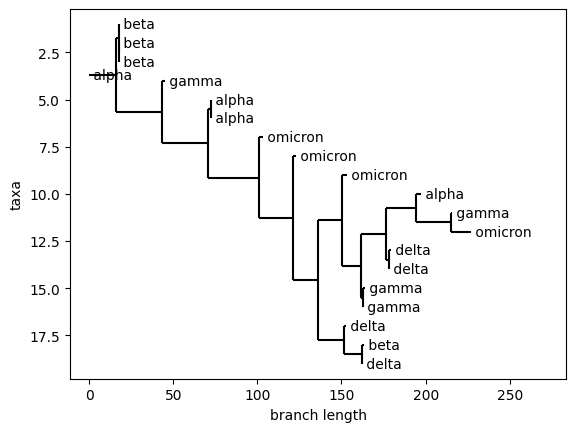

In [11]:
from Bio import Phylo

tree = Phylo.read('data/njtree_newick.dnd', 'newick')
tree.rooted = True
Phylo.draw(tree)